In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [50]:
import tensorflow as tf
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt



In [4]:
#load data
train_data = pd.read_csv(
    '/kaggle/input/nlp-getting-started/train.csv', 
    usecols=['text', 'target'], 
    dtype={'text': str, 'target': np.int64}
)

test_data = pd.read_csv(
    '/kaggle/input/nlp-getting-started/test.csv', 
    usecols=['text', 'id'], 
    dtype={'text': str, 'id': str}
)

In [5]:
print(len(train_data))
print(train_data['text'].head().values)

7613
['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']


In [6]:
#relabel some training data There are a number of examples in the training dataset that are mislabelled.

indicesto0=[4415, 4400, 4399,4403,4397,4396, 4394,4414, 4393,4392,4404,4407,4420,4412,4408,4391,4405,6840,6834,6837,6841,6816,6828,6831,
          3913,3914,3936,3921,3941,3937,3938,3136,3133,3930,3933,3924,3917,246,270,266,259,253,251,250,271,6119,6122,6123,6131,6160,
          6166,6167,6172,6212,6221,6230,6091,6108,7435,7460,7464,7466,7469,7475,7489,7495,7500,7525,7552,7572,7591,7599]
train_data.loc[indicesto0, 'target'] = 0
indicesto1 = [601,576,584,608,606,603,592,604,591, 587]
train_data.loc[indicesto1, 'target'] = 1



In [7]:
#define a few functions to clean the texts (regularized expressions used)
def remove_url(sentence):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', sentence)
def remove_at(sentence):
    url = re.compile(r'@\S+')
    return url.sub(r'', sentence)
def remove_html(sentence):
    html = re.compile(r'<.*?>')
    return html.sub(r'', sentence)
def remove_emoji(sentence):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', sentence)
def remove_stopwords(sentence):
    words = sentence.split()
    words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)
#also shorten words to stems
stemmer = SnowballStemmer('english')

def stem_words(sentence):
    words = sentence.split()
    words = [stemmer.stem(word) for word in words ]
    
    return ' '.join(words)
def clean_text(data):
    data['text'] = data['text'].apply(lambda x : remove_url(x))
    data['text'] = data['text'].apply(lambda x : remove_at(x))
    data['text'] = data['text'].apply(lambda x : remove_html(x))
    data['text'] = data['text'].apply(lambda x : remove_emoji(x))
    data['text'] = data['text'].apply(lambda x : remove_stopwords(x))
    data['text'] = data['text'].apply(lambda x : stem_words(x))
    
    return data
test_data = clean_text(test_data)
train_data = clean_text(train_data)
train_data['text'].head().values

array(['our deed reason #earthquak may allah forgiv us',
       'forest fire near la rong sask. canada',
       'all resid ask shelter place notifi officers. no evacu shelter place order expect',
       '13,000 peopl receiv #wildfir evacu order california',
       'just got sent photo rubi #alaska smoke #wildfir pour school'],
      dtype=object)

In [12]:
#now encode the texts to tokens
alldata = pd.concat([train_data['text'], test_data['text']],ignore_index=True)
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(alldata)
encoded_train = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(train_data['text']), padding='pre')
encoded_test = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(test_data['text']), padding='pre')

In [13]:
encoded_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  633, 7223,
        522,  281,  134, 1704, 2360,   48], dtype=int32)

In [18]:
label=train_data['target']
label

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [28]:
# we can now visualize certain word distribution in the training set and labels
label.value_counts()


0    4380
1    3233
Name: target, dtype: int64

In [29]:
unique, counts=np.unique(encoded_train, return_counts=True)

In [31]:
#remove 0
unique, counts=unique[1:], counts[1:]

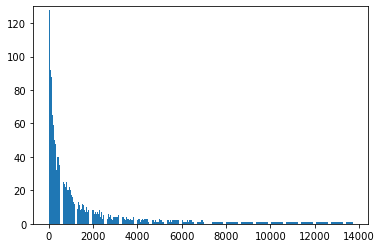

In [38]:
plt.ylim(0,130)
plt.bar(unique, counts)
plt.show()

In [54]:
#now build models
#first model contains simple RNN as well as embedding layer.


In [45]:
# Vocbvulary Size
vocab_size = len(tokenizer.word_index) + 1
print('Size of Vocabulary : ', vocab_size)
# Maximum length for padding sequence
maxlen = max(len(x) for x in encoded_train)
print('Maximum length of tweet : ', maxlen)

Size of Vocabulary :  16552
Maximum length of tweet :  28


In [205]:
from tensorflow import keras
model1 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, 100, input_length = maxlen),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]



In [206]:
model1.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 28, 100)           1655200   
_________________________________________________________________
simple_rnn_29 (SimpleRNN)    (None, 28, 100)           20100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 2800)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 2801      
Total params: 1,678,101
Trainable params: 1,678,101
Non-trainable params: 0
_________________________________________________________________


In [105]:
label=label.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [106]:
np.unique(label, return_counts=True)

(array([0, 1]), array([4380, 3233]))

In [208]:
#train m1
history = model1.fit(
    encoded_train,
    label,
    epochs = 50,
    validation_split=0.1,
    callbacks = callbacks
)


Train on 6851 samples, validate on 762 samples
Epoch 1/50
6851/6851 [==============================] - 4s 569us/sample - loss: 0.0398 - accuracy: 0.9829 - val_loss: 1.0358 - val_accuracy: 0.7192
Epoch 2/50
6851/6851 [==============================] - 4s 587us/sample - loss: 0.0392 - accuracy: 0.9820 - val_loss: 1.0167 - val_accuracy: 0.7310
Epoch 3/50
6851/6851 [==============================] - 4s 569us/sample - loss: 0.0394 - accuracy: 0.9816 - val_loss: 0.9754 - val_accuracy: 0.7283
Epoch 4/50
6851/6851 [==============================] - 4s 570us/sample - loss: 0.0381 - accuracy: 0.9831 - val_loss: 1.0907 - val_accuracy: 0.7165
Epoch 5/50
6851/6851 [==============================] - 4s 570us/sample - loss: 0.0371 - accuracy: 0.9832 - val_loss: 0.9667 - val_accuracy: 0.7270
Epoch 6/50
6851/6851 [==============================] - 4s 571us/sample - loss: 0.0368 - accuracy: 0.9847 - val_loss: 0.9821 - val_accuracy: 0.7244
Epoch 7/50
6851/6851 [==============================] - 4s 564us/

Epoch 47/50
6851/6851 [==============================] - 4s 579us/sample - loss: 0.0231 - accuracy: 0.9888 - val_loss: 1.0659 - val_accuracy: 0.7244
Epoch 48/50
6816/6851 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9887
Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.
6851/6851 [==============================] - 4s 565us/sample - loss: 0.0231 - accuracy: 0.9888 - val_loss: 1.0659 - val_accuracy: 0.7244
Epoch 49/50
6851/6851 [==============================] - 4s 566us/sample - loss: 0.0231 - accuracy: 0.9888 - val_loss: 1.0659 - val_accuracy: 0.7244
Epoch 00049: early stopping


In [161]:
#now model2 use embedding layer and Bidirectional LSTM
model2 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, 100, input_length = maxlen),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]


In [195]:
model2.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 28, 100)           1655200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 1,889,953
Trainable params: 1,889,953
Non-trainable params: 0
_________________________________________________________________


In [162]:
#train m2
history = model2.fit(
    encoded_train,
    label,
    epochs = 50,
    validation_split=0.1,
    callbacks = callbacks
)


Train on 6851 samples, validate on 762 samples
Epoch 1/50
6851/6851 [==============================] - 26s 4ms/sample - loss: 0.6749 - accuracy: 0.5779 - val_loss: 0.6716 - val_accuracy: 0.5538
Epoch 2/50
6851/6851 [==============================] - 20s 3ms/sample - loss: 0.6149 - accuracy: 0.6831 - val_loss: 0.5236 - val_accuracy: 0.7638
Epoch 3/50
6851/6851 [==============================] - 20s 3ms/sample - loss: 0.3989 - accuracy: 0.8342 - val_loss: 0.4436 - val_accuracy: 0.8031
Epoch 4/50
6851/6851 [==============================] - 20s 3ms/sample - loss: 0.3167 - accuracy: 0.8768 - val_loss: 0.4614 - val_accuracy: 0.8005
Epoch 5/50
6851/6851 [==============================] - 19s 3ms/sample - loss: 0.2553 - accuracy: 0.9096 - val_loss: 0.4920 - val_accuracy: 0.7848
Epoch 6/50
6851/6851 [==============================] - 20s 3ms/sample - loss: 0.2082 - accuracy: 0.9279 - val_loss: 0.5356 - val_accuracy: 0.7808
Epoch 7/50
6851/6851 [==============================] - 20s 3ms/sample 

In [210]:
pred1 = model1.predict(encoded_test)
pred2 = model2.predict(encoded_test)

In [211]:
pred1rd=pred1.round().astype(np.int64)
pred2rd=pred2.round().astype(np.int64)

In [215]:
sub1 = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
sub1["target"] = pred1rd
sub1.to_csv("submit_1.csv", index=False)

In [214]:
sub2 = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
sub2["target"] = pred2rd
sub2.to_csv("submit_2.csv", index=False)